# Autocodificador Variacional Convolucional: Conv-VAE

# – Variational AutoEncoder –


**basado en**

Ejemplo de VAE con Tesorflow.Keras F. Chollet, Convolutional Variational AutoEncoder (VAE) trained on MNIST digits Creado 2020/05/03, última versión: 2020/05/03.

Ejemplo de Cápitulo 3 de D. Foster, Generative deep learning, OReilly, 2019

Adaptado a tensorflow.keras: Mariano Rivera, Agosto 2021. Ver 1.0

Recomendamos al lector que si busca una derivación de las VAE mas rigurosa, vea las notas anteriores. En esta nota pretendimos dar una enfoque complementario al que habíamos usado y ser mas intuitivos.

Los ejemplos anteriores de autocodificadores variacionales (VAE) presentados en estas notas presenta los detalles de la derivación de los mismos. Ahora, ya que hemos revisado la teoría, tomaremos un enfoque más pŕactico para motivar la versión convolucional de estos autocodificadores (Conv-VAE).

En este ejercicio revisaremos:

1. Uso de Tensorflow.datasets para leer un directorio que contienen las imágenes de rostros de la base de datos CelebA.

2. Derivación de la clase Model para definir los modelos que componen nuestro VAE.

3. Definición del paso de entrenamiento en nuestro modelo VAE con el cálculo de la función de pérdida ELBO

4. Especificación de las métricas con que revisamos el avance del entrenamiento

5. Defición de una función callback que permite salvar los pesos del modelo total cada vez que en el entrenamiento se tienen una mejora en la pérdida.

6. Recuparer un modelo a partir de su creación y cargar los pesos previamente.

7. Analizar el comportamiento de la VAE.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
from glob import glob
import numpy as np

gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# CelebA Dataset

La base de datos (BD) CelebA fue recolectada por Lui et al. (2015) y consiste de mas de 200 mil imágenes de rostros de personas famosas (celebridades) a las cuales se le asocia un vector de 40 atributos binarios (sexo,pelo castaño, bigote, variación de pose, etc.) que presentan una gran variación de la pose y del fondo. Sin embargo dicha base de datos presenta un gran sesgo sobrerepresentando gente jóven, causásica y atractiva. Otras razas como los latinos estan sub-representadas, por ello han aparecido nuevas BD que tratan de mitigar este problema, como FairFace por Kärkkäinen and J. Joo (2021). A pesar del sesgo implícito en CelebA, ésta es una fuente inicial para probar algoritmos, sin embargo tengamos siempre en cuenta que lelvar un aloritmo entrabnado con una particular base de datos a producción conlleva un etapa de validación con datos del dominio real.

CelabA ha sido ampliamente utilizada para desarrollar algoritmos de reconocimiento de atributos faciales, detección de rostros, localización de puntos de referencia (o partes faciales) y edición y síntesis de rostros. La BD contiene

* 202,599 imágenes de caras, de

* 10,177 personas distintas, con 4

* 40 atributos binarios anotados por imagen.

(Lui et al., 2015) Z. Lui et al. Deep Learning Face Attributes in the Wild, Proc ICCV 2015.

(Kärkkäinen and Joo, 2021) K. Kärkkäinen and J. Joo, “FairFace: Face Attribute Dataset for Balanced Race, Gender, and Age for Bias Measurement and Mitigation,” 2021 IEEE Winter Conference on Applications of Computer Vision (WACV), 2021, pp. 1547-1557, doi: 10.1109/WACV48630.2021.00159.

Hemos descargado CelebA a nuestra estación de trabajo en el directorio /home/mariano/Data/celebA/imgs_align/img_align_celeba_png. Las imágenes de interés son las que corresponden a las imágenes aproximadamente alineadas respecto a los ojos de los rostros.

A continuación definimos variables globales para nuetro ejemplo.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
gdd.download_file_from_google_drive(file_id   = '1M-fbpy_qyBXAuoEvctc663kb4rUuv4SF',
                                    dest_path = './data/img_align_celeba.zip',
                                    unzip     = True)

In [ ]:
gdd.download_file_from_google_drive(file_id   = '1zIVb2lPxKaqILJtrE0Co00ZxxX9V7dxp',
                                    dest_path = './data/list_attr_celeba.txt',
                                    unzip     = False)

In [ ]:
# run params
DATA_FOLDER   = './data/img_align_celeba'
INPUT_DIM     = (128,128,3)
LATENT_DIM    = 150

# Parameters for label codification
ENC_LABEL_DIM = 10
DEC_LABEL_DIM = 10

BATCH_SIZE    = 384
R_LOSS_FACTOR = 100000  # 10000
EPOCHS        = 400
INITIAL_EPOCH = 0

filenames       = np.array(glob(os.path.join(DATA_FOLDER, '*.jpg')))
n_images        = filenames.shape[0]
steps_per_epoch = n_images//BATCH_SIZE

print('num image files : ', n_images)
print('steps per epoch : ', steps_per_epoch)

num image files :  202599
steps per epoch :  527


# Vectores de Valores

In [ ]:
LABELS_FILE = './data/list_attr_celeba.txt'

In [ ]:
def get_labels (LABELS_FILE) :
    # Read file
    with open(LABELS_FILE) as f:
      contents = f.readlines()
      # get labels's names
      names = contents[1].split(' ')
      # Remove jumps
      contents = [content.split('\n')[0] for content in contents[2:]]
      # ignore img names
      ids    = []
      labels = []
      for line in contents :
        tmp = line.split(' ')
        ids.append(tmp[0])
        labels.append(tmp[1:])

      true_labels = []
      # Remove empty characters
      for id, label in zip(ids,labels) :
        true_labels.append([x for x in label if x])
    return names[:-1], np.array(true_labels, dtype = np.float32)

In [ ]:
names, labels = get_labels(LABELS_FILE)

In [ ]:
labels.shape

(202599, 40)

Las imágenes las cargaremos en memoria, ajustando su tamaño a $ (128,128,3)$ y su rango dinámico (canales) a $[0,1][0,1]$.

En Tensorflow 1.x era muy popular usar `data_generators`. Estos nos permitían conectar un lector iterativo a las imágenes y preprocesarlas al momento de su lectura. Ahora,
en Tensorflow 2.x los generadres han sido reemplazados por tensorflow.datasets que permiten tener una funcionalidad similar a los generadores pero son más eficienes en cuanto a la parelización de tareas: es posible leer las imágenes y preprocesarlas en los distintos núcleos (cores) del CPU mientras el GPU procesa el lote previo de datos y realiza el paso de entrenamiento. Como planeamos entrenar por varias épocas, es necesario indicar que una vez que hayamos leido suficientes lotes para agotar la BD, la lectura deberá repetirse desde el inicio, para ello usamos el método `repeat()`.

Con la variable `tf.data.AUTOTUNE` dejaremos la responsabilidad de lanzar tantas tareas paralelas al Tensorflow en la parte de carga y proprocesamiento del lote de datos. Este es un avance significativo en la mejora de la eficiencia del entrenamiento, pues `Python` no está diseñado para lanzar tareas concurrentes. El indicando con el método `prefetch` nos permite usar los núcleos del CPU para leer y cargar los datos (lotes o batches) a la vez que el GPU esta realizando cálculos. Es recomendable realizar la carga de datos, pues ajustará las dimensiones de ls imágenes, antes de aplicar el preprocesamiento de cada dato en el lote mediante el map de una función lambda. Este map es un método de Datasets que también se puede realizarse en paralelo.

En nuestro caso, obtuvimos una mejora de 10x al pasar de generators a datasets. Y no solo eso, nuestra pretención de usar hilos (threads) en el proceso de entrenamiento mediante fit_generator llegó a congelarse.

In [ ]:
DATA_FOLDER   = './data/img_align_celeba/'

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
dataset = tf.keras.utils.image_dataset_from_directory(directory  = DATA_FOLDER, 
                                                      labels     = None,
                                                      batch_size = 1, 
                                                      image_size = INPUT_DIM[:2],
                                                      shuffle    = False,)

dataset = dataset.prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
dataset = dataset.map(lambda x: (normalization_layer(x)), num_parallel_calls=AUTOTUNE)

Found 202599 files belonging to 1 classes.


In [ ]:
label_dataset = tf.data.Dataset.from_tensor_slices(labels)

In [ ]:
merge_dataset = tf.data.Dataset.zip((dataset.unbatch(), label_dataset))
merge_dataset = merge_dataset.batch(BATCH_SIZE).repeat()

In [ ]:
for img, lab in merge_dataset.take(1) :
    print(img.shape, lab.shape)

(384, 128, 128, 3) (384, 40)


A continuación mostramos como leer un lote con la librería dataset. Note que se usa el método `take` y se indica que lote que se carga. El lote es un tensor de dimensión *(batch_size, heigth, width, n_channels)*. Para ilustrar los datos del lote cargado desplegamos las primeras las imágenes, previamente transformadas a formato `numpy` para poder emplear `matplotlib.pyplot.imshow`.

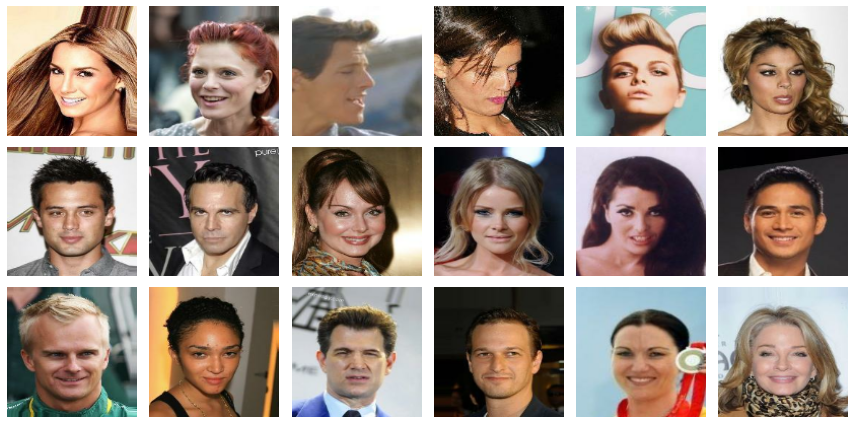

TensorShape([384, 128, 128, 3])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), tight_layout=True)
    
for images, _ in merge_dataset.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

plt.show()
        
images.shape 

A continuación definimos los modelos que a su vez componen el modelo VAE.

Partimos de un autocodificador simple como el mostrado en la siguiente figura.


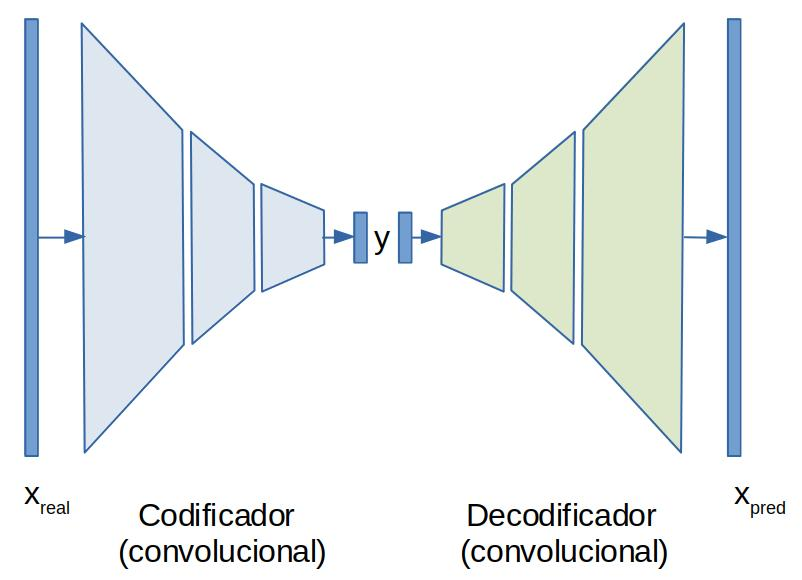

Podemos ver que consta de dos bloques, el codificador que matemáticamente se puede representar como:

$ y = C (x_r; \theta_c$)

donde $ x_r \in \mathbb{R}^m$ y $ y \in \mathbb{R}^n$  Lo importante aqui es que $ n > m$, es decir el vector  $ y $ codifica y comprime la información del vector $ x $. Luedo de decodificador toma el vector codificado $ y $ y recupera (o al menos aproxima) al vector $ x_{r}$ , denotamos por $ x_{p}$ la reconstrucción. El decodificador lo denotamos por

$x_p = D(y; \theta_d)$

Los parámetros $\theta = [ \theta_c, \theta_d]$ del autocodificador se calculan resolviendo
\begin{equation}
  \theta^* = \arg \min_\theta  L(x_r, x_p)
\end{equation}

donde $L$ es una métrica del error de recostrucción.

A continuación mostramos las implementaciónes de los modelos Encoder y Decoder que conforman un autoencoder. Las implementaciones consideran que los datos son las imágenes de la BD CelebA, el vector codificado es de dimensión `LATENT_DIM`.

In [ ]:
from tensorflow import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

Como además estamos interesados en agregar el vector de valores característicos como entrada, ahora nuestro encoder recibirá dos entradas, [$x_{real}$, $v_{real}$]. Dicho vector entrará a una capa densa para luego fusionarse con la codificación resultante de la imagen original. El esquema se verá como



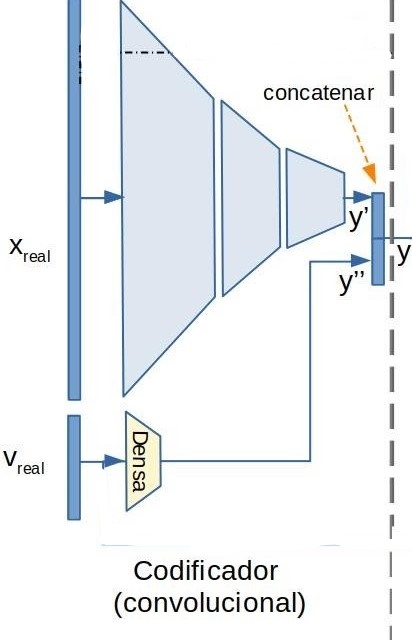


# Encoder

In [ ]:
class Encoder(keras.Model):
    def __init__(self, input_dim, output_dim, label_dim,
                 encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides, 
                 use_batch_norm=True, use_dropout=True, **kwargs):
        '''
        '''
        super(Encoder, self).__init__(**kwargs)

        self.input_dim                 = input_dim
        self.output_dim                = output_dim
        # Dense output for label
        self.label_dim                 = label_dim
      
        self.encoder_conv_filters      = encoder_conv_filters
        self.encoder_conv_kernel_size  = encoder_conv_kernel_size
        self.encoder_conv_strides      = encoder_conv_strides
        self.n_layers_encoder          = len(self.encoder_conv_filters)
        self.use_batch_norm            = use_batch_norm
        self.use_dropout               = use_dropout

        self.model = self.encoder_model()
        self.built = True
             
    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({"units": self.units})
        return config
    
    def encoder_model(self):
        '''
        '''
        encoder_input = layers.Input(shape = self.input_dim, name ='encoder')
        label         = layers.Input(shape = 40, name = 'label')

        x = encoder_input
        
        for i in range(self.n_layers_encoder):            
            x = Conv2D(filters     = self.encoder_conv_filters[i],
                       kernel_size = self.encoder_conv_kernel_size[i],
                       strides     = self.encoder_conv_strides[i],
                       padding     = 'same',
                       name        = 'encoder_conv_' + str(i),)(x)
            if self.use_batch_norm: 
                x = BatchNormalization()(x)
            x = LeakyReLU()(x)
            if self.use_dropout:    
                x = Dropout(rate = 0.25)(x)
                
        self.last_conv_size = x.shape[1:]
        x     = Flatten()(x)
        y_one = Dense(self.output_dim)(x)


        # Dense for codify label
        y_two = Dense(self.label_dim, name = 'v_real')(label)

        encoder_output = layers.Concatenate()([y_one, y_two])
        
        # Change to receive to inputs
        model = keras.Model([encoder_input, label], encoder_output)
        return model
        
        
    def call(self, inputs):
        '''
        '''
        img, label = inputs
        return self.model([img, label]) 


# Decoder

De la misma forma que el encoder, el decoder recibirá tanto la imagen original como el vector de características. El esquema completo queda como

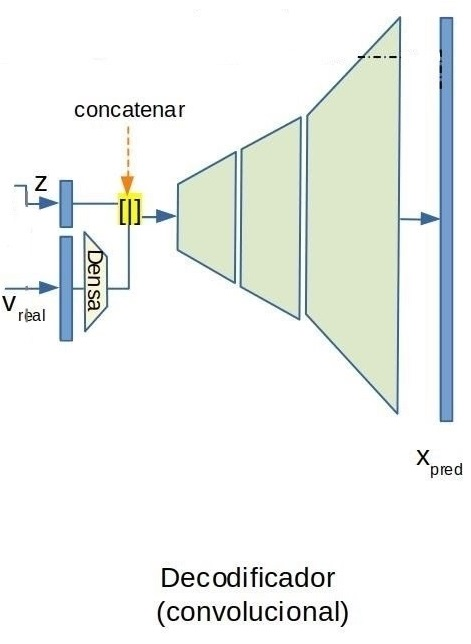

In [ ]:
class Decoder(keras.Model):
    def __init__(self, input_dim, input_conv_dim, label_dim,
                 decoder_conv_t_filters, decoder_conv_t_kernel_size, decoder_conv_t_strides, 
                 use_batch_norm=True, use_dropout=True, **kwargs):

        '''
        '''
        super(Decoder, self).__init__(**kwargs)

        self.input_dim                 = input_dim
        self.input_conv_dim            = input_conv_dim

        self.label_dim                 = label_dim
                
        self.decoder_conv_t_filters    = decoder_conv_t_filters 
        self.decoder_conv_t_kernel_size= decoder_conv_t_kernel_size
        self.decoder_conv_t_strides    = decoder_conv_t_strides
        self.n_layers_decoder          = len(self.decoder_conv_t_filters)
        
        self.use_batch_norm            = use_batch_norm
        self.use_dropout               = use_dropout

        self.model = self.decoder_model()
        self.built = True
             
    def get_config(self):
        config = super(Decoder, self).get_config()
        config.update({"units": self.units})
        return config
    
    def decoder_model(self):
        '''
        '''    
        decoder_input = layers.Input(shape = self.input_dim, name='decoder' )
        label         = layers.Input(shape = 40, name='label')
        
        # Dense for codify label
        # v_real        = Dense(self.label_dim, name="v_real")(label)
        x            = layers.Concatenate()([decoder_input, label])

        x = Dense(np.prod(self.input_conv_dim))(x)
        x = Reshape(self.input_conv_dim)(x)

        for i in range(self.n_layers_decoder):
            x = Conv2DTranspose(filters     = self.decoder_conv_t_filters[i],
                                kernel_size = self.decoder_conv_t_kernel_size[i],
                                strides     = self.decoder_conv_t_strides[i],
                                padding     = 'same',
                                name        = 'decoder_conv_t_' + str(i))(x)
            if i < self.n_layers_decoder - 1:

                if self.use_batch_norm:   
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:      
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)
        decoder_output = x
        model = keras.Model([decoder_input, label], decoder_output)
        return model
        
    def call(self, inputs):
        '''
        '''
        return self.model(inputs) 

# Generador de datos a partir de un Autocodificador


El propósito de tenemos es estimar la distribución $ P(X)$ de los datos para luego poderla muestrear, es decir generar muestras $ x \sim P(X)$ tal que se cumpla:

1. Las imágenes generadas sean similares a los de la BD de entrenamiento, rostros en CelebA.

2. El generador es paramétrizado por un vector de variables latentes (de menor dimensión que las imágenes) las cuelas tienen una distribución conocida y simple de muestrear.

3. El generador es capaz de generar datos que, aunque similares (rostros), no esten presentes en la BD de entrenamiento; no es una simple memoria.

El primer punto lo podriamos satisfacer con un autocodificador simple: asuminedo al vector $ y $ de la figura anterior el vector de espacio latentes. Sin embargo, para el punto dos no es claro que distribución $ P(Y) $ tiene $ y $. Por lo tanto, no podemos obtener nuevas muestras del espacio latente 

$ y^\prime \sim P(Y) $ 

para generar nuevos datos. es decir no podemos hacer

$ x' = D(y') $

El punto tres es aun mas complejo, ¿que pasa si utiliza una $ y^\prime$ que caen entre las $ Y $ de la BD? ¿Estará en ese punto definida la $ P(y^\prime)$? ¿correponderá a algo como un rostro? Es decir, ¿Tendrá suficiente poder de generalización el podrá para procesar variables latentes no vistas dureate el entrenamiento?

Los puntos dos y tres están muy relacionados, si las variables latentes tienen una distribución simple monomodal será fácil de muestrear. Además debemos imponer regularidad en  $P(Y)$: imágenes similares provienen de variables latentes similares.

Aquí es donde entran en acción los autoencodificadores variacionales.

Primero, lo que haremos es dejar a $y$ con su distribución extraña que tiene y a partir de ella obtener una muestra de variable latente $z$ que se distribuye en forma simple: $ z \sim \mathcal{N}(0,I)$. Es tienen una distribución Gaussiana multivariada con media cero y varianza igual a uno en cada variable. Para desarrollar esta parte hagamos la siguiente suposición, tenemos varias muestras tomadas de una misma persona, tal vez de una pequeña secuencia de un video, luego dichas muestras varian ligeramente entre ellas. Entonces es de esperarse que también sus variables latentes sean similares y caigan alrededor de una media (para la persona específica) y su variabilidad esté determinada por una varianza (igualmente para dicha persona). Ahora, si tenemos varios videos de rostros para distintas personas, cada uno de ellos tendra su propia media y varianza. A lo que vamos es que dada rostro tienen en realidad una pequeña distribución, como una nube alrededor de un punto (su media individual). Si muestreamos dicha nube debemos tener imágenes del rostro de una misma persona con ligeras variaciones: como de pose de posición de las cejas, de los labios, etc. Con ello lograríamos imponer regularidad a nuestra distribución.

Como solo tenemos rostros aislados y no videos, lo que haremos es que cada rostro $ x_i $ genera una codificación $ y_i $ en forma determinista, pero dicha codificación puede producir distintas variables latentes $ \{z_i\}_t $, con una distribución individual $ P(z_i)$. Luego impondremos a que distribución de toda la población  $ P(Z) = \prod_i P(z_i)$ sea la normal multivariada $ \mathcal{N}(0,I))$. Con ello logramos que las $ P(z_i)$ se concentren y no se dispercen dejando huecos y sea fácil de generar nuevas $ z^\prime $ que produzcan rostros realistas.

Queremos algo como lo siguiente

$ x \overset{C}{\mapsto} y \overset{S}{\leadsto} z \overset{D} {\mapsto}\hat x $

Sin embargo el problema es que la función $S$ es estocástica y en principio no podriamos impelementar la retropropagación del gradiente desde el error (pérdida) hacia el codificador.

la forma de darle la vuelta a este problema es usar el llamado truco de la parametrización que consiste en estimar la media $ \mu_i $ y la varianza $ \sigma^2_i$ de la distribución y luego calcular $ z_i = \mu_i + \sigma \epsilon $ donde $ \epsilon $ se distribuye normal $ \mathcal{N}(0,1) $. Eso lo podemos ver como

$ x \overset{C}{\mapsto} y \overbrace{ \overset{f}{\mapsto} (\mu , \sigma^2) \overset{g}{\mapsto} }^{S} z \overset{D}{\mapsto} \hat x $ 

donde $f $ representa una transformación mediante capas densas y $ g $ el truco de la parametrización:

$ z_i = \mu_i + \sigma \epsilon \text{ con } \epsilon \sim \mathcal{N}(0,1) $.

# Sampler

A continuación implementamos el modelo `Sampler` que realiza la tarea arriba descrita. En este caso, el Sampler del modelo no condicional y el condicional se mantiene sin cambios.

In [ ]:
class Sampler(keras.Model):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def __init__(self, latent_dim,  **kwargs):
        super(Sampler, self).__init__(**kwargs)
        self.latent_dim = latent_dim + 10
        self.model      = self.sampler_model()
        self.built      = True

    def get_config(self):
        config = super(Sampler, self).get_config()
        config.update({"units": self.units})
        return config
    
    def sampler_model(self):
        '''
        input_dim is a vector in the latent (codified) space
        '''
        input_data = layers.Input(shape=self.latent_dim)
        z_mean     = Dense(self.latent_dim, name="z_mean")(input_data)
        z_log_var  = Dense(self.latent_dim, name="z_log_var")(input_data)

        self.batch = tf.shape(z_mean)[0] 
        self.dim   = tf.shape(z_mean)[1]

        epsilon = tf.keras.backend.random_normal(shape=(self.batch, self.dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        model = keras.Model(input_data, [z, z_mean, z_log_var])
        return model
        
    def call(self, inputs):
        '''
        '''
        return self.model(inputs)

Noten que el componente estocástico (generación de $ \epsilon$) esta fuera del la ruta de cálculo desde los datos hasta el error y que dicho componente estocástico no tienen parámetros que requieran ser entrenados.

La siguiente figura ilustra al autoencodificador variacional.

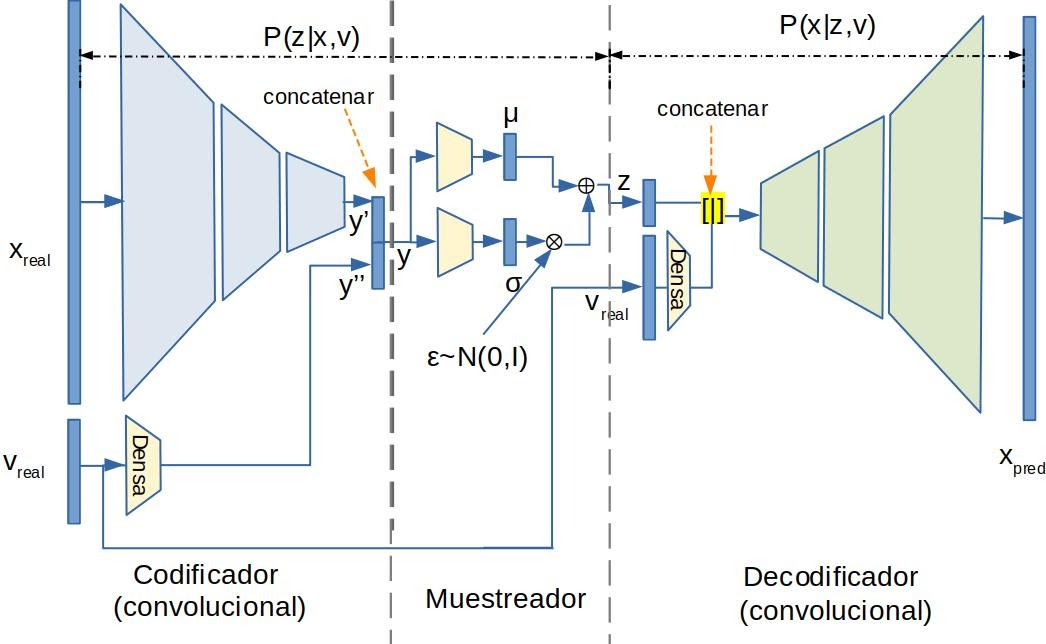

# VAE

import os
os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";  Ahora implementamos el modelo del VAE. Es importante que la función de costo incluya los siguientes elementos:

1. Error de reconstucción. Medir la discrepancia entre la imágen de entrada $ x_i $ y la imagen reconstruida $ \hat x_i $.

2. Desviación de distribución de las variables latentes $ P(Z) $ respecto ala normal multivariada $ \mathcal{N}(0,I)$.

Para el primer punto usaremos la el Error Absoluto Promedio (MAE) y para el segundo la divergencia de Kullback-Leibler entre distribuciones, que por ser Gaussianas no correlacionadas y una de ellas la normal $ \mathcal{N}(0,I) $ toma una forma muy simple. Usaremos el parámetro `R_LOSS_FACTOR` para ponderar cada uno de los errores.

Adicionalmente, hemos preferido en esta nota implementar el método `train_step` que corresponde a lo realizado dentro del lazo de entrenamiento. Con ello pretendemos mostrar como se implementa, se evalua una párdida (loss) particular y como se definen los valores a los que el proceso de entrenamiento da seguimiento: `loss`, `loss_reconstruction` y `loss_kl`.

Usamos también una `callback` que nos permite salvar los pesos del modelo cada vez que se logre una mejora en `loss`.

In [ ]:
class VAE(keras.Model):
    def __init__(self, r_loss_factor=1, summary=False, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.r_loss_factor             = r_loss_factor

        # Architecture
        self.input_dim                 = INPUT_DIM
        self.latent_dim                = LATENT_DIM

        self.encoder_label_dim         = ENC_LABEL_DIM
        self.decoder_label_dim         = 40

        self.encoder_conv_filters      = [64,64,64,64]
        self.encoder_conv_kernel_size  = [3,3,3,3]
        self.encoder_conv_strides      = [2,2,2,2]
        self.n_layers_encoder          = len(self.encoder_conv_filters)

        self.decoder_conv_t_filters    = [64,64,64,3]
        self.decoder_conv_t_kernel_size= [3,3,3,3]
        self.decoder_conv_t_strides    = [2,2,2,2]
        self.n_layers_decoder          = len(self.decoder_conv_t_filters)

        self.use_batch_norm            = True
        self.use_dropout               = True
    
        self.total_loss_tracker          = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker             = tf.keras.metrics.Mean(name="kl_loss")
        self.mae                         = tf.keras.losses.MeanAbsoluteError()

        # Encoder
        self.encoder_model = Encoder(input_dim                = self.input_dim,
                                     output_dim               = self.latent_dim,
                                     label_dim                = self.encoder_label_dim,
                                     encoder_conv_filters     = self.encoder_conv_filters, 
                                     encoder_conv_kernel_size = self.encoder_conv_kernel_size, 
                                     encoder_conv_strides     = self.encoder_conv_strides, 
                                     use_batch_norm           = self.use_batch_norm, 
                                     use_dropout              = self.use_dropout)
        
        self.encoder_conv_size = self.encoder_model.last_conv_size
        if summary: 
            self.encoder_model.summary()
        
        # Sampler
        self.sampler_model = Sampler(latent_dim  = self.latent_dim)     
        if summary: 
            self.sampler_model.summary()

        # Decoder
        self.decoder_model = Decoder(input_dim                 = self.latent_dim + 10, 
                                     input_conv_dim            = self.encoder_conv_size,
                                     label_dim                 = self.decoder_label_dim,
                                     decoder_conv_t_filters    = self.decoder_conv_t_filters,
                                     decoder_conv_t_kernel_size= self.decoder_conv_t_kernel_size, 
                                     decoder_conv_t_strides    = self.decoder_conv_t_strides, 
                                     use_batch_norm            = self.use_batch_norm, 
                                     use_dropout               = self.use_dropout)
        print('Decoder pass')
        if summary: self.decoder_model.summary()
        
        self.built = True

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,]

    @tf.function
    def train_step(self, data):
        '''
        '''        
        with tf.GradientTape() as tape:
            
            # predict
            x                    = self.encoder_model([data[0], data[1]])
            z, z_mean, z_log_var = self.sampler_model(x) 
            pred                 = self.decoder_model([z, data[1]])

            # loss
            r_loss     = self.r_loss_factor * self.mae(data[0], pred)
            kl_loss    = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss    = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = r_loss + kl_loss
        
        # gradient
        grads = tape.gradient(total_loss, self.trainable_weights)
        # train step
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # compute progress
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(r_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss":                self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss":             self.kl_loss_tracker.result(),}
    
    @tf.function
    def generate(self, z_sample, label):
        '''
        We use the sample of the N(0,I) directly as  
        input of the deterministic generator. 
        '''
        return self.decoder_model([z_sample, label])

    @tf.function
    def codify(self, images, label):
        '''
        For an input image we obtain its particular distribution:
        its mean, its variance (unvertaintly) and a sample z of such distribution.
        '''
        x = self.encoder_model.predict(images, label)
        z, z_mean, z_log_var= self.sampler_model(x)
        return z, z_mean, z_log_var
    
    # implement the call method
    @tf.function
    def call(self, inputs, training=False):
        '''
        '''   
        img, label = inputs.get_single_element()
                
        tmp1, tmp2 = self.encoder_model.use_dropout,self.decoder_model.use_dropout
        if not training:
            self.encoder_model.use_dropout, self.decoder_model.use_dropout = False,False

        x                    = self.encoder_model([img, label])
        z, z_mean, z_log_var = self.sampler_model(x) 
        pred                 = self.decoder_model([z, label])
        
        self.encoder_model.use_dropout, self.decoder_model.use_dropout = tmp1, tmp2
        return pred

# Train

## Compile

In [ ]:
vae = VAE(r_loss_factor=R_LOSS_FACTOR, summary=True)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 160)               728560    
Total params: 728,560
Trainable params: 728,048
Non-trainable params: 512
_________________________________________________________________
Model: "sampler"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         [(None, 160), (None, 160) 51520     
Total params: 51,520
Trainable params: 51,520
Non-trainable params: 0
_________________________________________________________________
Decoder pass
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 128, 128, 3)       936579    
Total params: 936,579
Trainable params: 936,195
Non-trainable para

In [ ]:
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  728560    
_________________________________________________________________
sampler (Sampler)            multiple                  51520     
_________________________________________________________________
decoder (Decoder)            multiple                  936579    
Total params: 1,716,665
Trainable params: 1,715,763
Non-trainable params: 902
_________________________________________________________________


In [ ]:
vae.compile(optimizer=keras.optimizers.Adam())


# Guardamos modelo en drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = '/content/drive/MyDrive/cimat/best_weight_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
callbacks = [checkpoint]

In [ ]:
# Probamos forward
vae(merge_dataset.take(1)).shape

TensorShape([384, 128, 128, 3])

## Fit

Entrenamos con el procedimiento normal de keras: invocando al método `fit`. Sin embargo, internamente el lazo de entrenamiento estará llamando a nuestra implementación de `train_step`.

In [ ]:
vae.fit(merge_dataset, 
        batch_size      = BATCH_SIZE,
        epochs          = EPOCHS,
        initial_epoch   = INITIAL_EPOCH,
        steps_per_epoch = steps_per_epoch,
        callbacks       = callbacks,)

Epoch 1/400
527/527 [==============================] - 437s 824ms/step - loss: 14007.2728 - reconstruction_loss: 9942.4746 - kl_loss: 302.5195

Epoch 00001: loss improved from inf to 10244.99609, saving model to /content/drive/MyDrive/CIMAT/Tercer_Semestre/Aprendizaje_Máquina_II/t01/model/best_weight_model.h5
Epoch 2/400
527/527 [==============================] - 438s 830ms/step - loss: 7165.9444 - reconstruction_loss: 6577.2676 - kl_loss: 383.6021

Epoch 00002: loss improved from 10244.99609 to 6960.87158, saving model to /content/drive/MyDrive/CIMAT/Tercer_Semestre/Aprendizaje_Máquina_II/t01/model/best_weight_model.h5
Epoch 3/400
527/527 [==============================] - 433s 821ms/step - loss: 6571.8337 - reconstruction_loss: 6084.0176 - kl_loss: 396.5614

Epoch 00003: loss improved from 6960.87158 to 6480.57520, saving model to /content/drive/MyDrive/CIMAT/Tercer_Semestre/Aprendizaje_Máquina_II/t01/model/best_weight_model.h5
Epoch 4/400
527/527 [==============================] 

## Continuamos entrenamiento

In [ ]:
vae.load_weights('/content/drive/MyDrive/cimat/best_weight_model.h5')

In [ ]:
vae.fit(merge_dataset, 
        batch_size      = BATCH_SIZE,
        epochs          = EPOCHS - 17,
        initial_epoch   = INITIAL_EPOCH,
        steps_per_epoch = steps_per_epoch,
        callbacks       = callbacks,)

Epoch 1/383
527/527 [==============================] - 421s 794ms/step - loss: 5847.6245 - reconstruction_loss: 5136.3594 - kl_loss: 389.7747

Epoch 00001: loss improved from inf to 5526.12842, saving model to /content/drive/MyDrive/cimat/best_weight_model.h5
Epoch 2/383
527/527 [==============================] - 418s 792ms/step - loss: 5403.4044 - reconstruction_loss: 5008.8174 - kl_loss: 387.3212

Epoch 00002: loss improved from 5526.12842 to 5396.13818, saving model to /content/drive/MyDrive/cimat/best_weight_model.h5
Epoch 3/383
527/527 [==============================] - 418s 793ms/step - loss: 5384.9846 - reconstruction_loss: 4998.0156 - kl_loss: 386.0117

Epoch 00003: loss improved from 5396.13818 to 5384.02295, saving model to /content/drive/MyDrive/cimat/best_weight_model.h5
Epoch 4/383
527/527 [==============================] - 415s 787ms/step - loss: 5370.4095 - reconstruction_loss: 4983.9150 - kl_loss: 385.4215

Epoch 00004: loss improved from 5384.02295 to 5369.33740, savin

In [ ]:
vae.load_weights('/content/drive/MyDrive/cimat/best_weight_model.h5')

In [ ]:
vae.fit(merge_dataset, 
        batch_size      = BATCH_SIZE,
        epochs          = EPOCHS - 17 - 31,
        initial_epoch   = INITIAL_EPOCH,
        steps_per_epoch = steps_per_epoch,
        callbacks       = callbacks,)

Epoch 1/352
527/527 [==============================] - 219s 412ms/step - loss: 5477.9144 - reconstruction_loss: 4902.3472 - kl_loss: 371.8918

Epoch 00001: loss improved from inf to 5274.23779, saving model to /content/drive/MyDrive/cimat/best_weight_model.h5
Epoch 2/352
527/527 [==============================] - 218s 412ms/step - loss: 5223.5839 - reconstruction_loss: 4845.0000 - kl_loss: 371.7261

Epoch 00002: loss improved from 5274.23779 to 5216.72217, saving model to /content/drive/MyDrive/cimat/best_weight_model.h5
Epoch 3/352
527/527 [==============================] - 217s 412ms/step - loss: 5218.1466 - reconstruction_loss: 4843.9067 - kl_loss: 371.4595

Epoch 00003: loss improved from 5216.72217 to 5215.36572, saving model to /content/drive/MyDrive/cimat/best_weight_model.h5
Epoch 4/352
527/527 [==============================] - 217s 411ms/step - loss: 5213.2928 - reconstruction_loss: 4842.7773 - kl_loss: 371.1385

Epoch 00004: loss improved from 5215.36572 to 5213.91699, savin

In [ ]:
vae.load_weights('/content/drive/MyDrive/cimat/best_weight_model.h5')

In [ ]:
vae.fit(merge_dataset, 
        batch_size      = BATCH_SIZE,
        epochs          = EPOCHS - 17 - 31 - 332,
        initial_epoch   = INITIAL_EPOCH,
        steps_per_epoch = steps_per_epoch,
        callbacks       = callbacks,)

Epoch 1/20
527/527 [==============================] - 221s 419ms/step - loss: 5084.8372 - reconstruction_loss: 4680.3857 - kl_loss: 361.7533

Epoch 00001: loss improved from inf to 5042.13867, saving model to /content/drive/MyDrive/cimat/best_weight_model.h5
Epoch 2/20
527/527 [==============================] - 220s 416ms/step - loss: 5031.7755 - reconstruction_loss: 4670.3179 - kl_loss: 361.9082

Epoch 00002: loss improved from 5042.13867 to 5032.22266, saving model to /content/drive/MyDrive/cimat/best_weight_model.h5
Epoch 3/20
527/527 [==============================] - 220s 417ms/step - loss: 5032.3349 - reconstruction_loss: 4670.8779 - kl_loss: 361.8334

Epoch 00003: loss did not improve from 5032.22266
Epoch 4/20
527/527 [==============================] - 219s 415ms/step - loss: 5031.7587 - reconstruction_loss: 4670.7744 - kl_loss: 361.9339

Epoch 00004: loss did not improve from 5032.22266
Epoch 5/20
527/527 [==============================] - 219s 415ms/step - loss: 5033.1910 - r

Muy bien terminamos el entrenamiento y salvamos los pesos de nuestro modelo, los que resultaron de la última época de entrenamiento.

In [ ]:
vae.save_weights('/content/drive/MyDrive/cimat/model_vae_faces_1e4.h5')

Sin embargo, sabemos que los mejores pesos no necesariamente correpondel a los calculados en la última época, como es el caso; sino a los que almacen nuestra `callback` en el archivo `"best_weight_model.h5"`.

Pero son solo los pesos, no el modelo completo. Para recuperar nuestro modelo debemos construirlo primero, lo llamamos `vae2` para distinguirlo del que usamos en entrenamiento. Una vez construido el modelo, cargamos en él los pesos salvados.

In [ ]:
vae2 = VAE(r_loss_factor=R_LOSS_FACTOR)

Decoder pass


In [ ]:
vae2.load_weights("/content/drive/MyDrive/cimat/best_weight_model.h5")

# Resultados

Como primer ejercicio generamos una variable en el espacio latente:

$ z \sim \mathcal{N}(0,I) $ 

Luego seleccionamos dos entradas de dicho vector: $ z_i $ y $ z_j $. Entonces dejando fijas todas las entradas de $z$ exepto $z_i$ y $z_j $ exploramos las imagenes que se generas variando dichas entradas.

Notamos que una variable (eje horizontal) parece que hace variar el rostro de tener características que van de masculinas a femeninas. La otra variable (eje vertical) parece asociarse con la sonrisa (alegría o tristeza del rostro).

Exploramos otras combinaciones de variables y vimos que algunas estan encontrar que estan asociadas con la orientacion del rostro, el grueso de las cejas, usar o no lentes, etc. Sin embargo notamos que lo que para un rostro es válido para otro no: la misma variable puedede star asociada a distintas características.

Podemos encontramos cierta analogía entre las variables latente y los cromosomas: así como gen puede asociarse a distintos fenotipos, o varios genes controlar un fenotipo; igual pasa con las variables latentes en nuestro generador. En nuestra analogia, el valor de una variable latente correponde a la expresión (real) de un gen (binario). Además la codificación “genética” en las variable latente cambia de entrenamiento a entrenamiento. Por lo que repetimos el entrenamiento, seguramente la figura generada abajo tenga distinta interpretación.

Notemos como el generador, aunque genera rostros pausibles, tienen dificultades para representar un fondo razonable, ello debido a la gran variabilidad de fondos en la BD CelebA.

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, input_size = (28,28,1), n = 30, figsize = 15,  scale = 1., latents_start = [0,1], label = np.zeros((1, 40))):
    # display a n*n 2D manifold of digits
    canvas = np.zeros((input_size[0]*n, input_size[1]*n, input_size[2]))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    z_sample = np.random.normal(0,1,(1,vae.latent_dim))

    # get codification of label by encoder
    encod     = vae.encoder_model([np.zeros((1, 128, 128, 3)), label])
    label_enc = np.expand_dims(encod[0][150:], axis = 0)
    z_sample = np.concatenate((z_sample, label_enc), axis = 1)



    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample[0][latents_start[0]], z_sample[0][latents_start[1]]=xi,yi
            x_decoded = vae.generate(z_sample, label)
            img = x_decoded[0].numpy().reshape(input_size)
            canvas[i*input_size[0] : (i + 1)*input_size[0],
                   j*input_size[1] : (j + 1)*input_size[1],
                   : ] = img

    plt.figure(figsize=(figsize, figsize))
    start_range    = input_size[0] // 2
    end_range      = n*input_size[0] + start_range
    pixel_range    = np.arange(start_range, end_range, input_size[0])
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[{}]".format(latents_start[0]))
    plt.ylabel("z[{}]".format(latents_start[1]))
    plt.imshow(canvas, cmap="Greys_r")
    plt.show()

Generamos aleatoriamente un vector de caracterísiticas

In [ ]:
def generate_label (size = 40) :
  label = np.random.randint(-1, 1, size = (1, 40))
  for i in range(label.shape[1]) :
    if label[0][i] == 0 :
      label[0][i] = 1

  return label

In [ ]:
generate_label()

array([[ 1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,
         1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1,
        -1,  1, -1, -1,  1,  1, -1,  1]])

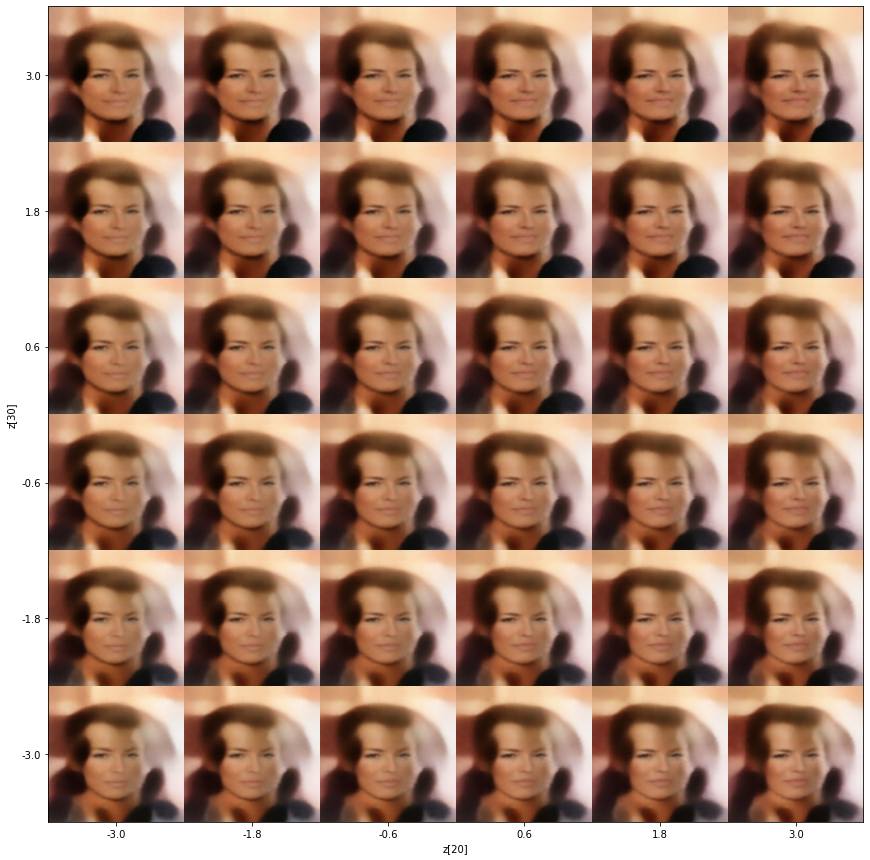

In [ ]:
plot_latent_space(vae2, input_size=INPUT_DIM, n = 6, latents_start=[20,30], scale=3, label = generate_label())

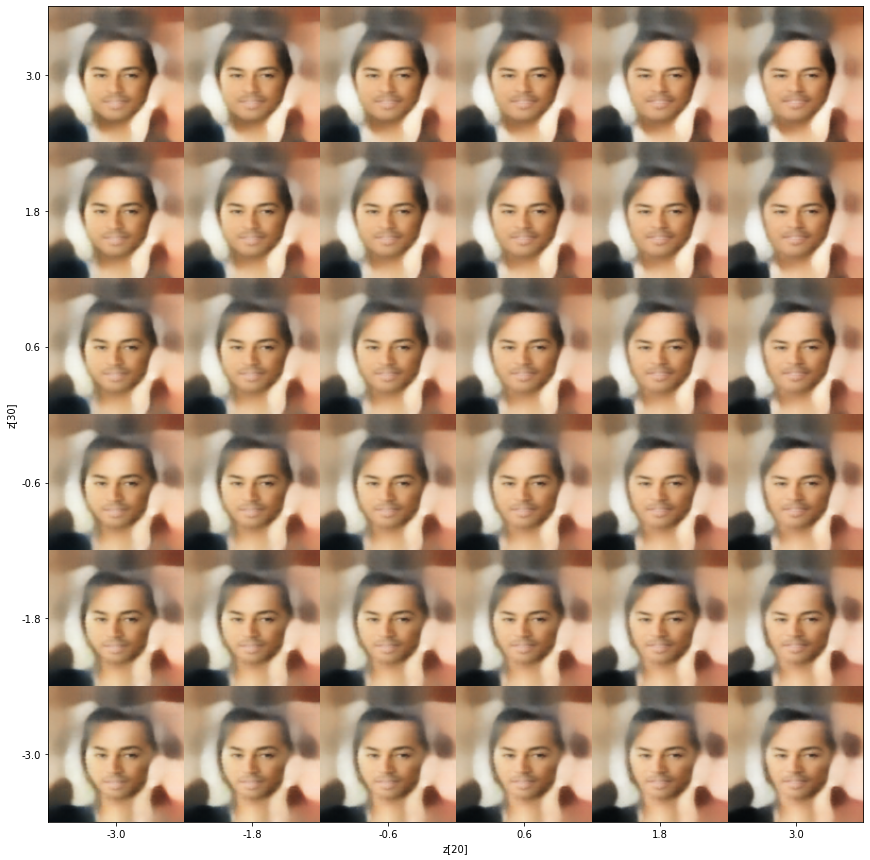

In [ ]:
plot_latent_space(vae2, input_size=INPUT_DIM, n = 6, latents_start=[20,30], scale=3, label = generate_label())

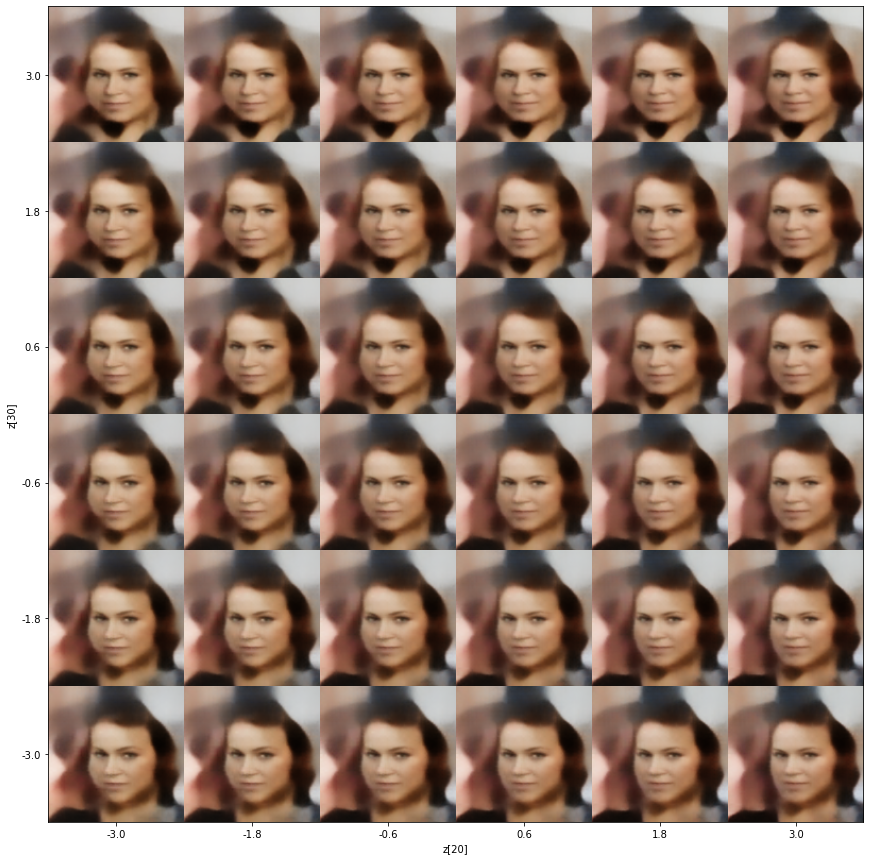

In [ ]:
plot_latent_space(vae2, input_size=INPUT_DIM, n = 6, latents_start=[20,30], scale=3, label = generate_label())

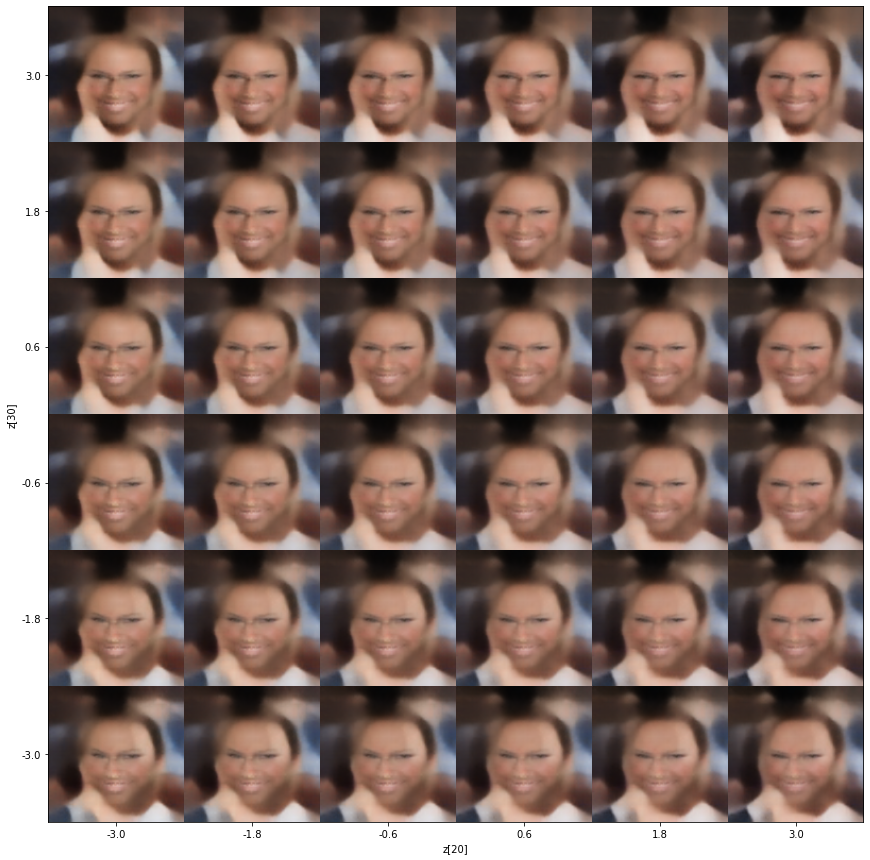

In [ ]:
plot_latent_space(vae2, input_size=INPUT_DIM, n = 6, latents_start=[20,30], scale=3, label = generate_label())

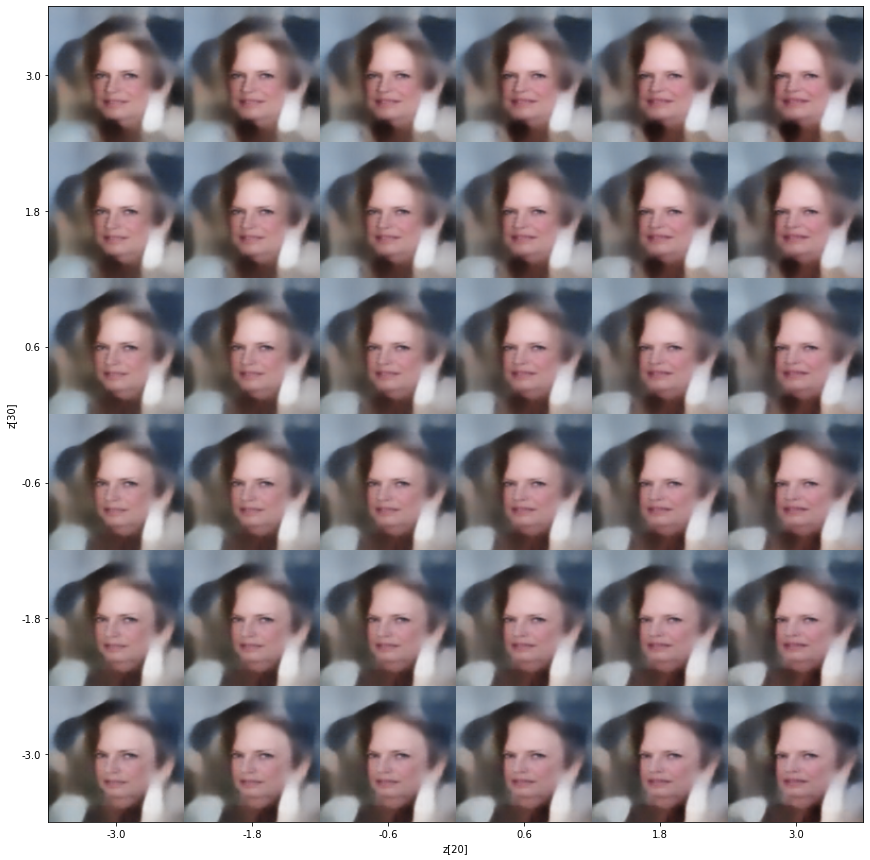

In [ ]:
plot_latent_space(vae2, input_size=INPUT_DIM, n = 6, latents_start=[20,30], scale=3, label = generate_label())

Ahora leemos un lote de imágenes de la BD. Las pasamos por el Codificador y Muestrador.

In [ ]:
images = merge_dataset.take(4)

In [ ]:
images

<TakeDataset shapes: ((None, 128, 128, 3), (None, 40)), types: (tf.float32, tf.float32)>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


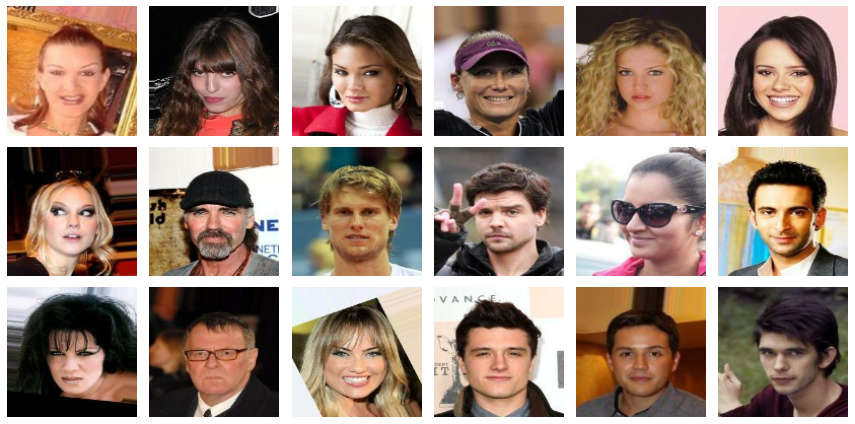

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), tight_layout=True)

for images_, _ in images:
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images_[i].numpy())
        plt.axis('off')

plt.show()

In [ ]:
for images_, labels_ in merge_dataset.take(4) :
  images = images_
  labels = labels_

In [ ]:
images.shape, labels.shape

(TensorShape([384, 128, 128, 3]), TensorShape([384, 40]))

In [ ]:
x = vae2.encoder_model.predict([images, labels])
print(x.shape)
z, z_mean, z_log_var = vae2.sampler_model(x)

(384, 160)


In [ ]:
z.shape, z_mean.shape, z_log_var.shape

(TensorShape([384, 160]), TensorShape([384, 160]), TensorShape([384, 160]))

In [ ]:
z_mean[46]

<tf.Tensor: shape=(160,), dtype=float32, numpy=
array([-0.92604846,  0.34891832, -0.03019297,  0.5247946 , -0.00900584,
       -0.5446056 ,  0.5198851 ,  1.5822381 ,  0.03259381, -0.39192483,
        0.95135844,  0.5510489 , -0.1511816 , -1.1519684 ,  0.67198473,
       -1.0113156 ,  0.04257786,  0.5074855 , -0.49655202, -2.133575  ,
       -0.46451283,  0.57006943, -0.40449053,  0.7286953 ,  0.47239944,
        1.5857588 , -0.37773412, -0.12564108, -1.1612624 ,  0.86722976,
       -0.44001898,  0.7606024 ,  0.59525406,  0.715708  ,  2.179897  ,
        0.32141197,  1.1084708 , -1.3214558 ,  1.2405323 , -0.9282352 ,
        0.33256808,  0.09211753, -1.8426877 ,  0.21494824, -0.22097312,
       -0.6141386 , -0.2551766 , -1.1137427 ,  0.46623594,  0.31482497,
       -0.05468938,  0.19944371, -0.01668042,  0.08912325, -1.5761118 ,
       -0.57172424,  0.0740225 ,  0.8203984 ,  0.30052495, -0.20547703,
       -0.72564954, -0.15051284,  0.12583017,  1.8490629 , -0.13775352,
        0.304306

In [ ]:
z_mean[2]

<tf.Tensor: shape=(160,), dtype=float32, numpy=
array([ 0.9947711 ,  0.85087675, -0.82225394, -0.73105943, -0.01153427,
       -1.1704497 , -0.06011648,  1.6820155 , -0.01329541,  0.81036067,
        2.366147  ,  0.9316132 ,  0.14879279,  0.4855899 ,  2.7352421 ,
       -0.74430555,  0.13971215, -0.00972596,  0.37883016, -0.38898593,
        0.36560982, -0.32778734,  2.214242  , -1.6682366 , -0.32629934,
        0.48014808, -0.08323562, -0.47592348,  1.0104336 ,  0.8933591 ,
       -0.13209972, -1.6305743 , -0.49998775, -1.07097   ,  0.2678852 ,
        0.29882944, -2.625563  ,  2.7383108 , -0.23673128, -0.8800111 ,
        0.31684804,  1.1370273 ,  3.2264628 , -0.8975235 ,  0.8160584 ,
       -0.13264772,  0.39414483,  0.6232681 ,  2.548109  ,  1.3215994 ,
       -0.48225132, -0.3162188 ,  0.04154276, -1.4145012 ,  0.95831615,
       -0.21572241, -0.6324285 ,  0.17005613,  0.9538305 ,  0.88553584,
        1.2978224 , -0.03940621,  0.06928444, -2.3549097 ,  0.11350584,
       -1.786256

Ya tenemos para cada imágen $x_i $ el vector codificado $(z_i, \mu_i, \sigma^2_i)$. Ahora, seleccionamos dos imágenes al azar, digamos la $x_i$ y la $ x_j$. Entonces usamos su codificación: $\mu_i$ y $\mu_j$ y calculamos la combinación convexa de dichos vectores:

$ \mu_{\alpha}= (1-\alpha) \mu_i + \alpha\mu_j \;\;\; \text{para} \;\;\; \alpha \in [0,1]$ 

y generamos cada rostro de la combinación (de hecho solo unos pasos).

$\hat x_{\alpha} = D(\mu_{\alpha})$

y los mostramos las reconstrucciones. Los pasos intermedios muestran una transformación paulatina desde el rostro $ x_i $ al rostro $ x_j$ . Note que los pasos intermedios preservan la cualidad de aparentar ser un rostro y no son simple superposiciones de imágenes.

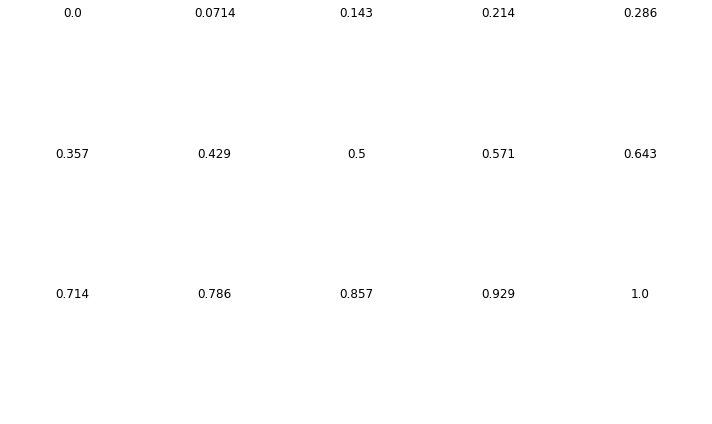

In [ ]:
def plot_warping(z1, z2, n=(1,5), label = generate_label()):
    
    n_trans = np.prod(n)

    f, axarr = plt.subplots(n[0],n[1], figsize=(10,6),  tight_layout=True)
    for i in range(n[0]):
        for j in range(n[1]):
            alpha = (i * n[1]+j)/(n_trans-1)
            z_new = (1-alpha)*z1 + alpha*z2
            z_new = tf.expand_dims(z_new, axis=0)
            x_decoded = vae.decoder_model([z_new, label])
            axarr[i,j].set_title("{:0.3}".format(alpha))
            axarr[i,j].axis('off')
    
    plt.show()

plot_warping(z1 = z_mean[2], z2 = z_mean[46], n = (3,5))

Nos resta revisar que tan Gaussianas es distribución $ P(Z) $. Elegimos para un lote de imágenes elegimos dosentradas de los vectores devariables latentes y desplegamos los puntos. Notamos que se concentran al rededor de $(0,0) $, no parecen estar correlacionadas y parace monomodal.

In [ ]:
for i in range(5):
    for img, lb in merge_dataset.take(1) :
      images_ = img
      labels_ = lb
    x = vae2.encoder_model.predict([images_, labels_])
    _, z_mean,_= vae2.sampler_model(x)
    if i:
        Z = np.concatenate((Z, z_mean), axis=0)
    else:
        Z = z_mean
        
Z = np.array(Z)
Z.shape   

(1920, 160)

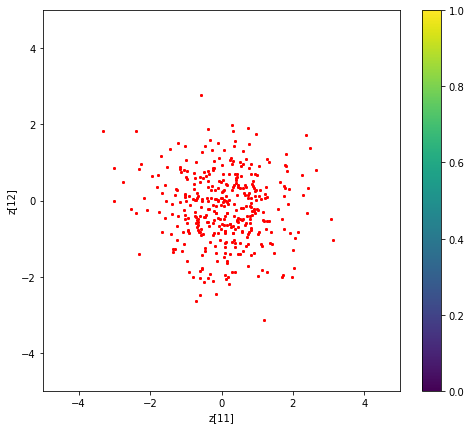

In [ ]:
def plot_label_clusters(xdata, ydata, limits=10):
    # display a 2D plot of the digit classes in the latent space
    plt.figure(figsize=(8,7))
    plt.scatter(xdata,ydata, s=(2,),c='r')
    plt.colorbar()
    plt.xlabel("z[11]")
    plt.ylabel("z[12]")
    plt.xlim([-limits,limits])
    plt.ylim([-limits,limits])
    plt.show()


xdata = Z[:,0]
ydata = Z[:,3]
plot_label_clusters(xdata=xdata, ydata=ydata, limits=5)

Obtenemos los histogramas para las primeras $ N $ entradas de las variabes latentes y se observamos cierta “Gaussianidad”; en algunas mas que otras. Aunque hemos preferido previlegiar buenas reconstrucciones que penalizar desviaciones de la Gaussiana, los histogramas lucen muy razonables.

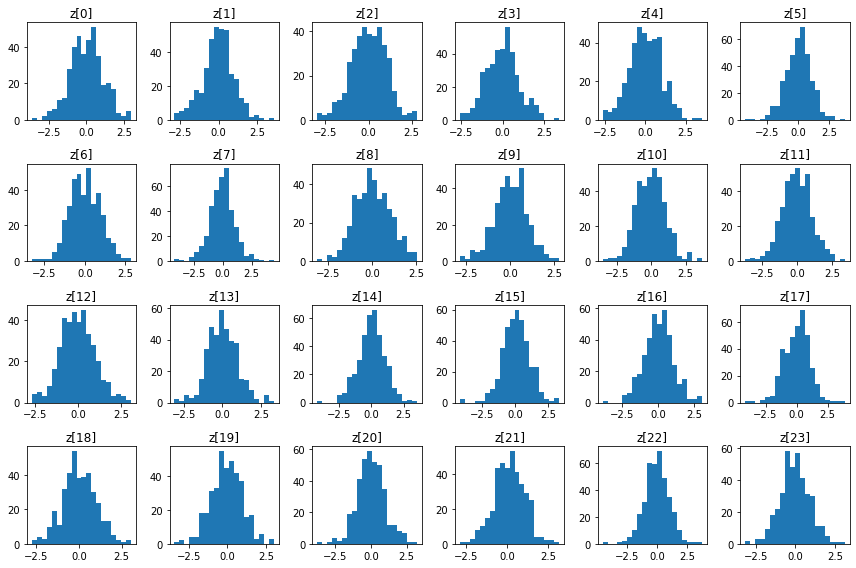

In [ ]:
nrows, ncols = 4,6
fig, axs = plt.subplots(nrows,ncols, figsize=(12,8), tight_layout=True)
n_bins = 20

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols+j
        vals = z[:,idx].numpy() 
        axs[i,j].hist(vals, bins=n_bins)
        axs[i,j].set_title("z[{}]".format(idx))

fig.tight_layout()
plt.show()